In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
train_raw = pd.read_csv("./ds_data/DataBase/train_data.csv")
test_df = pd.read_csv("./ds_data/DataBase/updated_test_data_20200728.csv")

/Users/yuhaibo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# /Users/yuhaibo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: 
# DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. 
# Specify dtype option on import or set low_memory=False. interactivity=interactivity, compiler=compiler, result=result)
train_raw.iloc[:, [19,47,55,112,123,124,125,128,129,130,133,139,140,141]].head()

,desc,next_pymnt_d,verification_status_joint,sec_app_earliest_cr_line,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,debt_settlement_flag_date,settlement_status,settlement_date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Requirement Scoping & Data Exploration
* This is a classification problem
* We have integer, float, string types of data
* We want to predict loan_status
* TODO: Show feature importance & industrial usage capability
* Hyper tuning

In [4]:
value_map = {'Charged Off': 1, 'Fully Paid': 0, 'Current': 0}
train_raw['loan_status'].replace(value_map, inplace=True)

train_raw.index = train_raw.index.set_names(['every_id'])
train_raw = train_raw.reset_index()

In [5]:
train_df, validate_df = train_test_split(train_raw, train_size=0.8, random_state=42)

In [6]:
train_df.sample(5)

,every_id,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
808947,808947,NaN,NaN,15000,15000,15000.0,36 months,12.74,503.54,C,C1,CEO,10+ years,MORTGAGE,103000.0,Source Verified,Dec-2016,0,n,NaN,NaN,debt_consolidation,Debt consolidation,021xx,MA,21.93,0.0,Oct-2001,0.0,NaN,NaN,20.0,0.0,8600,30.0,28.0,f,4753.95,4753.95,13065.50,13065.50,10246.05,2819.45,0.0,0.0,0.0,Feb-2019,503.54,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,86956.0,1.0,2.0,3.0,4.0,7.0,78356.0,82.0,1.0,7.0,2126.0,47.0,28700.0,2.0,2.0,2.0,11.0,4348.0,9967.0,44.3,0.0,0.0,16.0,182.0,6.0,6.0,0.0,6.0,NaN,7.0,NaN,0.0,5.0,7.0,11.0,14.0,4.0,17.0,24.0,7.0,20.0,0.0,0.0,0.0,4.0,100.0,18.2,0.0,0.0,113949.0,86956.0,17900.0,85249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1559554,1559554,NaN,NaN,15000,15000,15000.0,60 months,10.49,322.34,B,B3,Principal,10+ years,MORTGAGE,118500.0,Not Verified,Dec-2014,0,n,NaN,NaN,debt_consolidation,Debt consolidation,622xx,IL,24.66,1.0,Jul-1985,0.0,16.0,NaN,30.0,0.0,36475,56.8,58.0,w,3073.27,3073.27,16099.52,16099.52,11926.73,4172.79,0.0,0.0,0.0,Feb-2019,322.34,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,251578.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64200.0,NaN,NaN,NaN,4.0,9676.0,9973.0,69.7,0.0,0.0,158.0,353.0,22.0,3.0,3.0,26.0,NaN,2.0,16.0,0.0,6.0,13.0,8.0,15.0,15.0,24.0,40.0,13.0,30.0,0.0,0.0,0.0,2.0,98.3,50.0,0.0,0.0,339359.0,143675.0,32900.0,140216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
870295,870295,NaN,NaN,15000,15000,15000.0,36 months,11.49,494.57,B,B5,Dietary Manager,10+ years,RENT,60000.0,Verified,Oct-20

In [7]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(1461700, 146)
(365425, 146)
(211627, 146)


In [8]:
print(train_df.loc[train_df['loan_status'] == 0].shape)
print(train_df.loc[train_df['loan_status'] == 1].shape)
print("\n")
print(validate_df.loc[validate_df['loan_status'] == 0].shape)
print(validate_df.loc[validate_df['loan_status'] == 1].shape)

(1354809, 146)
(106891, 146)


(338790, 146)
(26635, 146)


In [9]:
(1354809-106891)/1354809

0.9211025317959949

&uarr; 92% of people have loan_status=0, this is pretty imbalanced, we can downsample in train_df and validate_df:

In [10]:
train_df_balanced_a = train_df[train_df['loan_status'] == 0].sample(int(1e5))
train_df_balanced_b = train_df[train_df['loan_status'] == 1].sample(int(1e5))
train_df_balanced = pd.concat([train_df_balanced_a, train_df_balanced_b], axis=0)
train_df_balanced.shape

(200000, 146)

In [11]:
validate_df_balanced_a = validate_df[validate_df['loan_status'] == 0].sample(int(2e4))
validate_df_balanced_b = validate_df[validate_df['loan_status'] == 1].sample(int(2e4))
validate_df_balanced = pd.concat([validate_df_balanced_a, validate_df_balanced_b], axis=0)
validate_df_balanced.shape

(40000, 146)

OK, let's see why people loan and how they distribute: &darr;

In [12]:
train_df['purpose'].unique()

array(['other', 'credit_card', 'moving', 'major_purchase', 'medical',
       'debt_consolidation', 'vacation', 'house', 'home_improvement',
       'small_business', 'car', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

In [13]:
train_df[['purpose', 'loan_status']].groupby('purpose').count().sort_values(by='loan_status', ascending=False)

,loan_status
purpose,
debt_consolidation,824723
credit_card,342600
home_improvement,98119
other,88883
major_purchase,31639
medical,17453
car,14733
small_business,13894
vacation,9993


In [14]:
train_df[['purpose', 'every_id',
                   'loan_status']].groupby(['purpose','loan_status']).count().reset_index(level=1).drop('educational')

,loan_status,every_id
purpose,,
car,0,13952
car,1,781
credit_card,0,322308
credit_card,1,20292
debt_consolidation,0,758830
debt_consolidation,1,65893
home_improvement,0,91888
home_improvement,1,6231
house,0,8322


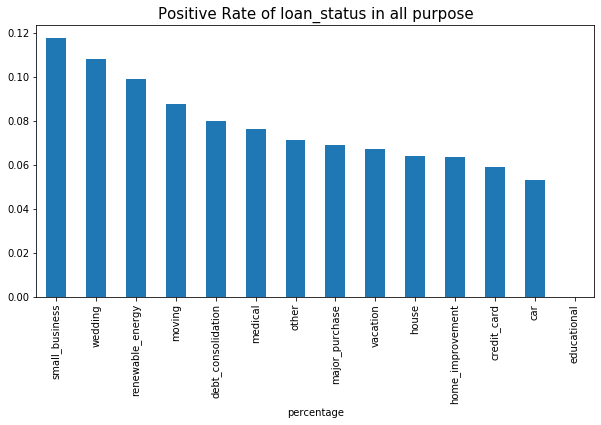

In [15]:
x = train_df[['purpose', 'every_id', 'loan_status']].groupby(['purpose']).apply(
    lambda x: x[x['loan_status']==1].shape[0] / x.shape[0]).sort_values(ascending=False)
# x = train_df[['purpose', 'every_id', 'loan_amnt', 'loan_status']].groupby(['purpose']).apply(
#     lambda x: x.loc[x['loan_status']==1, 'loan_amnt'].sum() / x['loan_amnt'].sum()).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,5))
x.plot.bar()
plt.xlabel('percentage')
plt.title("Positive Rate of loan_status in all purpose", fontsize=15)
plt.show()

&uarr; Seems those whose purpose is to run small business and to get wedding are more likely to be marked as 'Charged Off' at last.

In [16]:
train_df['hardship_flag'].describe()

count     1461700
unique          2
top             N
freq      1461694
Name: hardship_flag, dtype: object

&uarr; This feature is so so useless, and there are many other features like this, let me skip them.

# 0. Brainstorm

* Everything related to economics
* Include interest?
* binary: charged off VS current/paid off
* **Sometimes the data is imbalanced, we will try to make it balanced by sampling. I've heard of someone saying: in reality, we may want to take advantages of the imbalance so that we should keep the training data as is. Is this statement correct?** No, only in testing phase.

## 0.1. Definition based:

In [17]:
# charged_off: not paid
# paid_off: paid

In [18]:
# how to tell charged off from current? pay date? next_pymnt_d √

In [19]:
train_df_balanced[['issue_d','loan_amnt','funded_amnt','int_rate','last_pymnt_d', 'last_pymnt_amnt', 'total_pymnt','next_pymnt_d', 'annual_inc', 'loan_status']].head(10)

,issue_d,loan_amnt,funded_amnt,int_rate,last_pymnt_d,last_pymnt_amnt,total_pymnt,next_pymnt_d,annual_inc,loan_status
1218950,Mar-2017,17000,17000,12.74,May-2018,4.100000,19142.061345,NaN,74000.0,0
136192,Dec-2018,4900,4900,12.98,Feb-2019,165.060000,321.290000,Mar-2019,21000.0,0
1730960,Dec-2017,14000,14000,12.62,Feb-2019,315.830000,4397.080000,Mar-2019,80000.0,0
1520573,Jun-2013,7550,7550,14.09,Jun-2015,3153.300000,9094.010002,NaN,62000.0,0
1156813,Feb-2015,9000,9000,9.17,Mar-2018,286.520000,10324.135956,NaN,60000.0,0
380675,Jun-2018,7225,7225,17.47,Feb-2019,259.290000,2067.310000,Mar-2019,35000.0,0
903867,Dec-2015,10000,10000,7.26,Dec-2018,309.610000,11150.493957,NaN,43000.0,0
864995,Oct-2016,3500,3500,13.49,Jul-2017,2899.920000,3842.121356,NaN,29000.0,0
1212515,Mar-2017,16700,16700,18.99,Feb-2019,612.080000,14142.600000,Mar-2019,38000.0,0
880931,Oct-2016,1000,1000,13.49,Feb-2019,33.935528,952.140000,Mar-2019,35265.0,0


In [20]:
def loan_status_logic1(inp_df):
    """
    based on next_pymnt_d, total_payment, funded_amnt
    """
    temp_df = inp_df.copy()
    current_ind = temp_df['next_pymnt_d'].notna()
    paid_off_ind = (temp_df['total_pymnt'] >= temp_df['loan_amnt']) & (~current_ind)
    charged_off_ind = (temp_df['total_pymnt'] < temp_df['loan_amnt']) & (~current_ind)
    temp_df.loc[current_ind | paid_off_ind, 'prediction_score'] = 0
    temp_df.loc[charged_off_ind, 'prediction_score'] = 1
    return temp_df

In [21]:
valid_res = loan_status_logic1(validate_df_balanced)

In [22]:
accuracy_score(valid_res['loan_status'], valid_res['prediction_score'])

0.9689

In [23]:
f1_score(valid_res['loan_status'], valid_res['prediction_score'], average='binary')

0.9679017442460522

In [24]:
roc_auc_score(valid_res['loan_status'], valid_res['prediction_score'])

0.9689

### Let's translate this idea into ML pipeline:

In [25]:
ser1 = train_df_balanced[['next_pymnt_d','total_pymnt', 'loan_amnt','loan_status']].sample(frac=0.1).copy()
ser1['has_next_pymnt_d'] = ser1['next_pymnt_d'].notna()
ser1['is_paid_off'] = (ser1['total_pymnt'] >= ser1['loan_amnt']) & (ser1['next_pymnt_d'].isna())
ser1['is_current'] = (ser1['total_pymnt'] < ser1['loan_amnt']) & (ser1['next_pymnt_d'].notna())

X_train = ser1[['has_next_pymnt_d', 'is_paid_off', 'is_current']]
y_train = ser1['loan_status']

# for validate data, we actually don't want it to be balanced. (My understanding)
# ser1 = validate_df_balanced[['next_pymnt_d','total_pymnt', 'loan_amnt','loan_status']].copy()
ser1 = validate_df[['next_pymnt_d','total_pymnt', 'loan_amnt','loan_status']].copy()
ser1['has_next_pymnt_d'] = ser1['next_pymnt_d'].notna()
ser1['is_paid_off'] = (ser1['total_pymnt'] >= ser1['loan_amnt']) & (ser1['next_pymnt_d'].isna())
ser1['is_current'] = (ser1['total_pymnt'] < ser1['loan_amnt']) & (ser1['next_pymnt_d'].notna())

X_valid = ser1[['has_next_pymnt_d', 'is_paid_off', 'is_current']]
y_valid = ser1['loan_status']

#### RF:

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
# evaluate the performance of the Random Forest classifier
rf_scores = cross_val_score(rf, X_train, y_train, cv=10)
print('Random Forest score: %0.3f' % rf_scores.mean())

Random Forest score: 0.969


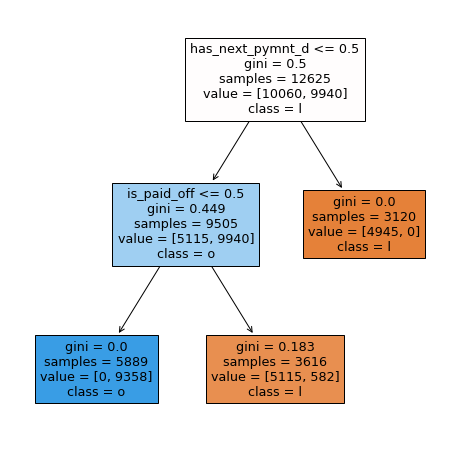

In [27]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8))
tree.plot_tree(rf.estimators_[0],
               feature_names = X_train.columns, 
               class_names=y_train.name,
               filled = True);
fig.savefig('rf_individualtree.png')
# code referrence 
# https://stackoverflow.com/questions/42621190/display-this-decision-tree-with-graphviz

#### Log Regression:

0.9954080864746528


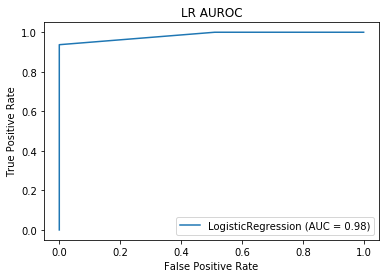

In [28]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42).fit(X_train, y_train)
print(log_reg.score(X_valid, y_valid))
plot_roc_curve(log_reg, X_valid, y_valid)
plt.title("LR AUROC")
plt.show()

#### SVM:

In [29]:
from sklearn.svm import SVC
svm = SVC(probability=True)

clf = svm.fit(X_train, y_train)
print('testing score:', clf.score(X_valid, y_valid))

# evaluate the performance of the SVM classifier
svm_scores = cross_val_score(svm, X_train, y_train, cv=10)
print('SVM score: %0.3f' % svm_scores.mean())


testing score: 0.9954080864746528
SVM score: 0.969


In [30]:
t = clf.predict_proba(X_valid)
roc_auc_score(y_valid, [item[1] for item in t])

0.9530873708154042

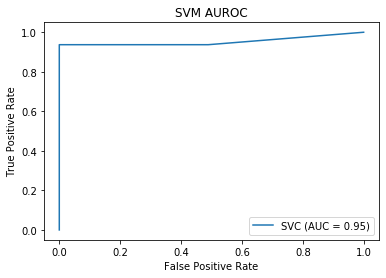

In [31]:
plot_roc_curve(clf, X_valid, y_valid)
plt.title("SVM AUROC")
plt.show()

**It's working well after training on balanced data and testing on imbalanced validation data. However, this definition based model seems to be using prori and circular reasoning.** (I'm not sure if this is allowed or normally seen in ML design in industry, need some feedback here.)  
We usually define *loan_status* by the money paid (paid_off->0, still_paying->0, not_paying->1), and this model is again, predicting loan_status by the money paid.


So, let's assume: These information are unavailable, or we don't know the definition of loan_status, or let's say we want to know the final loan_status from the begining as the banks give money to the person.


# 1. Feature selection:

We want to foresee if the person can pay off the loan at last. So it's better to predict it at the earliest stage.   
I'm using LR because I defined this task as a binary classification problem.  


## 1.1 Basic features:
I'm thinking of these features because they are very basic and easy to get:
* annual_inc
* addr_state
* loan_amnt
* verification_status

These information can be obtained before the bank makes loan commitment.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [33]:
train_df_balanced['verification_status'].unique()

array(['Source Verified', 'Verified', 'Not Verified'], dtype=object)

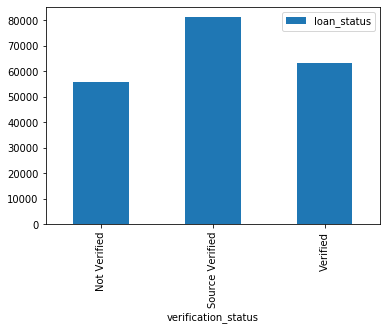

In [34]:
train_df_balanced[['verification_status', 
                   'loan_status']].groupby('verification_status').count().plot.bar()

&uarr; Verification status seems OK.

Text(0.5, 1.0, 'Annual income reported by every group in all states')

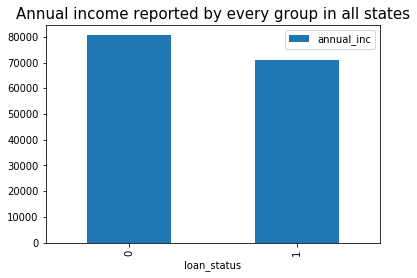

In [35]:
train_df_balanced[['annual_inc', 
                   'loan_status']].groupby('loan_status').mean().plot.bar()
plt.title('Annual income reported by every group in all states', fontsize=15)


&uarr; We can see the average reported income in group 0 is higher, this makes sense becase banks are more likely to loan to people that earn more.

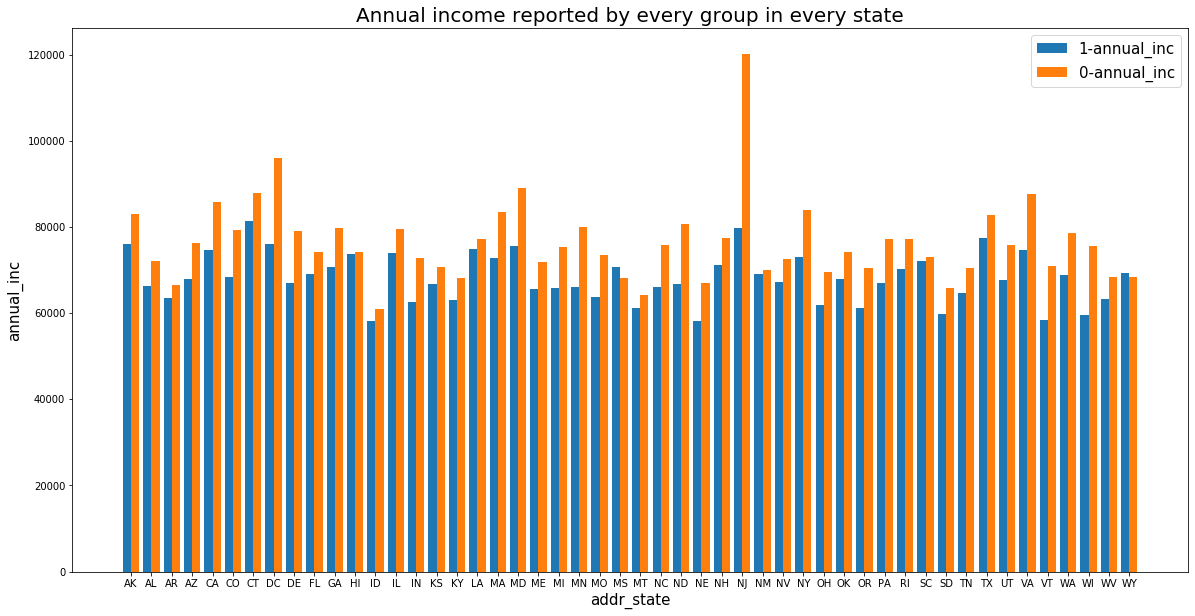

In [36]:
# code Referring:
# https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged

x = train_df_balanced[['annual_inc', 'addr_state',
                   'loan_status']].groupby(['addr_state','loan_status']).mean().reset_index(level=1)


ticks = list(x.index)[::2]
N = len(ticks)

blue_bar = x.loc[x['loan_status']==1, 'annual_inc'].values
orange_bar = x.loc[x['loan_status']==0, 'annual_inc'].values

ind = np.arange(N)
plt.figure(figsize=(20,10))
width = 0.4

# Plotting
plt.bar(ind, blue_bar , width, label='1-annual_inc')
plt.bar(ind + width, orange_bar, width, label='0-annual_inc')

plt.xlabel('addr_state',fontsize=15)
plt.ylabel('annual_inc',fontsize=15)
plt.title('Annual income reported by every group in every state', fontsize=20)

plt.xticks(ind + width / 2, ticks)
plt.legend(fontsize=15)
plt.show()

Above plot shows us the reported annual income by people from different loan_status in every state.  
We can see in some of the states, the income relationship in loan_status=0 and loan_status=1 are opposite with the previous plot (titled *Annual income reported by every group in all states*). Which might indicates people from some states are more likely to report a higher income than they actually earn. This sounds a little discriminative, so I'll stop here and not report the state names

Now let's take a look at how much do people loan in each State:

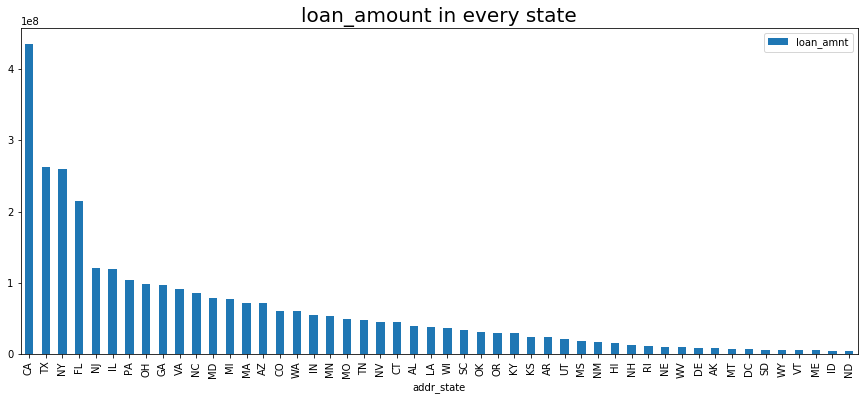

In [37]:
train_df_balanced[['addr_state', 
                   'loan_amnt',
                   ]].groupby(['addr_state']).sum().sort_values(['loan_amnt'],ascending=False).plot.bar(figsize=(15, 6))
plt.title('loan_amount in every state', fontsize=20)
plt.show()

&uarr; We can see from above that CA people really like to loan.  
CA, NY, TX, FL, IL, NJ, PA, OH are ranked top.  
Moreover, I see the loan_amount jumping from CA to NY and from FL to IL. Maybe it's due to difference in population, or maybe it's the difference in purpose of loan. (Housing, Landing, Car etc)   
This information is useful for marketing and advertising. I can dig further to find out whether it's due to population or something else, but I'll stop here because that's not our goal.

## 1.2 Baseline
We just chose some simple and basic features in Section 1.1 Basic Features.  
Now let's apply some models to make predictions.

In [38]:
ser1 = train_df_balanced[['annual_inc', 'loan_amnt', 'addr_state', 'verification_status', 'loan_status']].sample(frac=0.1).copy()

X_train_lg = ser1[['annual_inc', 'loan_amnt', 'verification_status', 'addr_state']]
X_train_lg = pd.concat([X_train_lg, pd.get_dummies(X_train_lg['verification_status'], prefix='income') ], axis=1)
X_train_lg = pd.concat([X_train_lg, pd.get_dummies(X_train_lg['addr_state'], prefix='state') ], axis=1)
y_train_lg = ser1['loan_status']


# for validate data, we actually don't want it to be balanced. (My understanding)
# ser1 = validate_df_balanced[['annual_inc', 'loan_amnt', 'addr_state', 'verification_status', 'loan_status']].copy()
ser1 = validate_df[['annual_inc', 'loan_amnt', 'addr_state', 'verification_status', 'loan_status']].copy()
X_valid_lg = ser1[['annual_inc', 'loan_amnt', 'verification_status', 'addr_state']]
X_valid_lg = pd.concat([X_valid_lg, pd.get_dummies(X_valid_lg['verification_status'], prefix='income') ], axis=1)
X_valid_lg = pd.concat([X_valid_lg, pd.get_dummies(X_valid_lg['addr_state'], prefix='state') ], axis=1)
y_valid_lg = ser1['loan_status']

X_train_lg.drop(['verification_status', 'addr_state'], axis=1, inplace=True)
X_valid_lg.drop(['verification_status', 'addr_state'], axis=1, inplace=True)

In [39]:
X_train_lg.columns

Index(['annual_inc', 'loan_amnt', 'income_Not Verified',
       'income_Source Verified', 'income_Verified', 'state_AK', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC',
       'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD',
       'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT',
       'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM',
       'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA',
       'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='object')

In [40]:
log_reg_1_2 = LogisticRegression(random_state=42).fit(X_train_lg, y_train_lg)
print(log_reg_1_2.predict(X_train_lg))
print(log_reg_1_2.predict_proba(X_train_lg))
print(log_reg_1_2.score(X_valid_lg, y_valid_lg))
# 为什么这个模型，加了新的column并不能提高performance？甚至概率一点都不变？
# [0 0 0 ... 0 1 0]
# [[0.54536421 0.45463579]
#  [0.58393102 0.41606898]
#  [0.54553633 0.45446367]
#  ...
#  [0.53194857 0.46805143]
#  [0.48326053 0.51673947]
#  [0.52767386 0.47232614]]
# 0.5859013477457755

[1 0 1 ... 1 0 1]
[[0.4816508  0.5183492 ]
 [0.50159763 0.49840237]
 [0.46681905 0.53318095]
 ...
 [0.4680434  0.5319566 ]
 [0.50790149 0.49209851]
 [0.4923467  0.5076533 ]]
0.5323773688171307


In [41]:
rf = RandomForestClassifier()

rf.fit(X_train_lg, y_train_lg)
print(rf.score(X_valid_lg, y_valid_lg))
rf_scores = cross_val_score(rf, X_train_lg, y_train_lg, cv=5)
print('Random Forest score: %0.3f' % rf_scores.mean())
# 0.5583635492919203
# Random Forest score: 0.548

0.5463118286926182
Random Forest score: 0.544


In [42]:
# SVM runs so slow here, so I removed it.

**To summarize, 
I trained Logistic Regression, Random Forest and SVM models on a *balanced* dataset, and the best model so far is LR, which has 55% accuracy (may vary when you rerun) on an *imbalanced* validation dataset**

## 1.2 Continuous features:

Some of the features in 2.1 are too sparse after one-hot-encoding, for example, State.   
Although there are some ways to optimize/avoid that, for example, grouping, embeddings, for simplicity, let try some denser or continuous features like **grade**, **tot_cur_bal**

In [43]:
ser1 = train_df_balanced[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'loan_status']].sample(frac=0.1, random_state=42).copy()
X_train_lg = ser1[['annual_inc', 'loan_amnt', 'tot_cur_bal']]
y_train_lg = ser1['loan_status']

ser1 = validate_df[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'loan_status']].copy()
X_valid_lg = ser1[['annual_inc', 'loan_amnt', 'tot_cur_bal']]
y_valid_lg = ser1['loan_status']


In [44]:
svm = SVC()
svm.fit(X_train_lg, y_train_lg)
print(svm.score(X_valid_lg, y_valid_lg))
# This return the mean accuracy on the given test data and labels.
# 0.48878429226243414

0.3803160703290689


In [45]:
# Code referrence: 
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
distributions = dict(logisticregression__C=uniform(loc=0, scale=4),
                     logisticregression__penalty=['l2'])
pipe = make_pipeline(StandardScaler(), LogisticRegression())
search = RandomizedSearchCV(pipe, distributions, random_state=42)
best_1_2 = search.fit(X_train_lg, y_train_lg)
print(best_1_2.score(X_valid_lg, y_valid_lg))
# 0.47111445577067795

0.4749675035917083


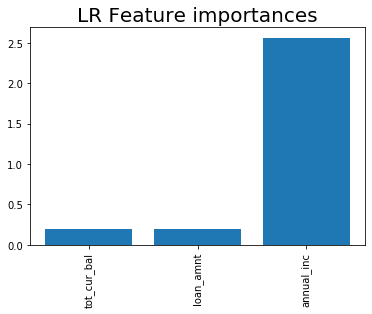

In [46]:
importances = pd.DataFrame(data={
    'Attribute': X_train_lg.columns,
    'Importance': abs(best_1_2.best_estimator_.named_steps['logisticregression'].coef_[0])
})
importances = importances.sort_values(by='Importance')
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('LR Feature importances', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [47]:
rf = RandomForestClassifier()

rf.fit(X_train_lg, y_train_lg)
# evaluate the performance of the Random Forest classifier
rf_scores = cross_val_score(rf, X_train_lg, y_train_lg, cv=10)
print('Random Forest score: %0.3f' % rf_scores.mean())

Random Forest score: 0.541


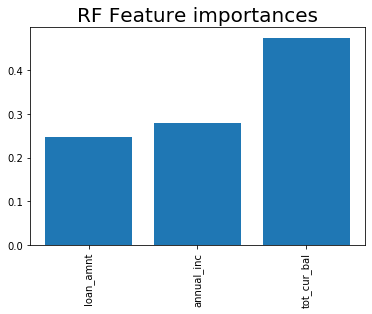

In [48]:
importances = pd.DataFrame(data={
    'Attribute': X_train_lg.columns,
    'Importance': abs(rf.feature_importances_)
})
importances = importances.sort_values(by='Importance')
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('RF Feature importances', size=20)
plt.xticks(rotation='vertical')
plt.show()

&uarr; We had some bad performances using same models based on chosen features. Even after a randomized search.  
Essentially, we just changed our features from categorical to continuous values. Maybe we should add more features.

## 1.3 Synthetic Features:

We did some simple feature engineering in Section 0.1 Definition Based models and Section 1.1 Baseline.  
Now let's do some more:

This cell shows the percentage of loan_status==1 in every sub_grade &darr;

In [49]:
train_df_balanced[['sub_grade', 'loan_status']].groupby('sub_grade').apply(lambda x: x[x['loan_status']==1].shape[0]/ x.shape[0]).reset_index()

,sub_grade,0
0,A1,0.102759
1,A2,0.148381
2,A3,0.171857
3,A4,0.206985
4,A5,0.275411
5,B1,0.314249
6,B2,0.334561
7,B3,0.383022
8,B4,0.420180
9,B5,0.445650


Interesting, the lower the sub-grade, the more likely the loan_status would be a 'Charged Off'.  
**Idea: Given the sub-grade, our model can just output the percentage of loan_status=1 in that sub-grade (as shown above) as the probability of loan_status=1, this might be a good guess.**

In [50]:
ser1 = train_df_balanced[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'loan_status', 'int_rate',
                          'mort_acc', 'num_sats', 'sub_grade'
                         ]].sample(frac=0.1).copy()
ser2 = train_df_balanced[['sub_grade', 'loan_status']].groupby('sub_grade').apply(lambda x: x[x['loan_status']==1].shape[0]/ x.shape[0]).reset_index()
ser2.columns = ['sub_grade', 'sub_grade_score']
ser1 = pd.merge(ser1, ser2, on='sub_grade')
X_train_lg = ser1[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'mort_acc', 'num_sats', 'sub_grade_score']]
y_train_lg = ser1['loan_status']



ser1 = validate_df[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'loan_status', 'int_rate',
                          'mort_acc', 'num_sats', 'sub_grade'
                         ]].sample(frac=0.1).copy()
ser2 = validate_df[['sub_grade', 'loan_status']].groupby('sub_grade').apply(lambda x: x[x['loan_status']==1].shape[0]/ x.shape[0]).reset_index()
ser2.columns = ['sub_grade', 'sub_grade_score']
ser1 = pd.merge(ser1, ser2, on='sub_grade')
X_valid_lg = ser1[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'mort_acc', 'num_sats', 'sub_grade_score']]
y_valid_lg = ser1['loan_status']

In [51]:
# Code referrence: 
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
distributions = dict(logisticregression__C=uniform(loc=0, scale=4),
                     logisticregression__penalty=['l2'])
pipe = make_pipeline(StandardScaler(), LogisticRegression())
search = RandomizedSearchCV(pipe, distributions, random_state=42)
best_1_3 = search.fit(X_train_lg, y_train_lg)
print(best_1_3.score(X_valid_lg, y_valid_lg))

0.9272617809643697


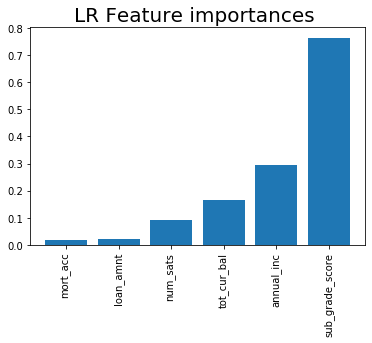

In [52]:
importances = pd.DataFrame(data={
    'Attribute': X_train_lg.columns,
    'Importance': abs(best_1_3.best_estimator_.named_steps['logisticregression'].coef_[0])
})
importances = importances.sort_values(by='Importance')
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('LR Feature importances ', size=20)
plt.xticks(rotation='vertical')
plt.show()

&uarr; Looks good, same LR and SVM models performed better on our feature-engineered data, comparing with 1.2 Continuous features. Thies indicates our new features are good.

Let's try something in NN, say a simple MLP:

In [53]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='sgd', alpha=1e-3, activation='relu',
                    hidden_layer_sizes=(16, 128, 8), random_state=1)

pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train_lg, y_train_lg)
print(pipe.score(X_train_lg, y_train_lg))
print(pipe.score(X_valid_lg, y_valid_lg))

0.6472
0.9272617809643697


&uarr; It's working OK, but validation data is 92% imbalanced itself. Maybe we should try to add more features and more data?

## 1.4 Even more features:

In [54]:
ser1 = train_df_balanced[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'loan_status', 'delinq_2yrs',
                          'mths_since_last_delinq','mths_since_last_record','open_acc','revol_bal','revol_util',
                          'total_acc','out_prncp_inv','total_pymnt','total_pymnt_inv',
                          'total_rec_int','total_rec_late_fee','collection_recovery_fee']].sample(frac=0.1, random_state=42).copy()
X_train_lg = ser1[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'delinq_2yrs',
                          'mths_since_last_delinq','mths_since_last_record','open_acc','revol_bal','revol_util',
                          'total_acc','out_prncp_inv','total_pymnt','total_pymnt_inv',
                          'total_rec_int','total_rec_late_fee','collection_recovery_fee']].fillna(value=1e-10)
y_train_lg = ser1['loan_status']

ser1 = validate_df[['annual_inc', 'loan_amnt', 'tot_cur_bal', 'loan_status','delinq_2yrs',
                          'mths_since_last_delinq','mths_since_last_record','open_acc','revol_bal','revol_util',
                          'total_acc','out_prncp_inv','total_pymnt','total_pymnt_inv',
                          'total_rec_int','total_rec_late_fee','collection_recovery_fee']].copy()
X_valid_lg = ser1[['annual_inc', 'loan_amnt', 'tot_cur_bal','delinq_2yrs',
                          'mths_since_last_delinq','mths_since_last_record','open_acc','revol_bal','revol_util',
                          'total_acc','out_prncp_inv','total_pymnt','total_pymnt_inv',
                          'total_rec_int','total_rec_late_fee','collection_recovery_fee']].fillna(value=1e-10)
y_valid_lg = ser1['loan_status']

&uarr; **Attention**: *I filled NA this time because the model is not able to handle*  
*Also, as long as you fill with the same scaled value, the result looks OK*

In [55]:
# Code referrence: 
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
distributions = dict(logisticregression__C=uniform(loc=0, scale=4),
                     logisticregression__penalty=['l2'])
pipe = make_pipeline(StandardScaler(),LogisticRegression(solver='liblinear'))
search = RandomizedSearchCV(pipe, distributions, random_state=42)
best_1_4 = search.fit(X_train_lg, y_train_lg)
print(best_1_4.score(X_valid_lg, y_valid_lg))

0.9986125743996717


&uarr; The same Logistic Regression performed better comparing with 1.2 Continuous features and 1.3 Synthetic Features.  

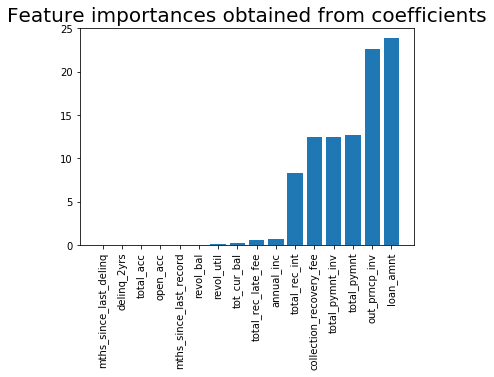

In [56]:
importances = pd.DataFrame(data={
    'Attribute': X_train_lg.columns,
    'Importance': abs(best_1_4.best_estimator_.named_steps['logisticregression'].coef_[0])
})
importances = importances.sort_values(by='Importance')
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

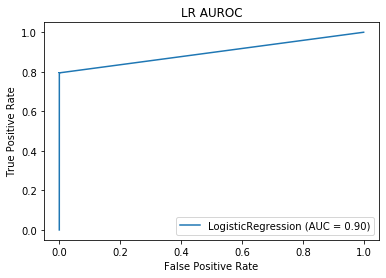

In [57]:
plot_roc_curve(best_1_4.best_estimator_.named_steps['logisticregression'], X_valid_lg, y_valid_lg)
plt.title("LR AUROC")
plt.show()

&uarr; Unlickily, the AUROC is not good enough.  
**But we learnt something from the example.**   
**We can use the top important features from those and build an NN &darr;**

In [58]:
# code referrence:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier
chosen_features = ['total_rec_int', 'total_pymnt', 'total_pymnt_inv', 
                   'collection_recovery_fee', 'out_prncp_inv', 'loan_amnt']
clf = MLPClassifier(solver='sgd', alpha=1e-3, activation='relu',
                    hidden_layer_sizes=(16, 128, 8), random_state=1)

pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train_lg[chosen_features], y_train_lg)
print(pipe.score(X_train_lg[chosen_features], y_train_lg))
print(pipe.score(X_valid_lg[chosen_features], y_valid_lg))

0.99655
0.999570363275638


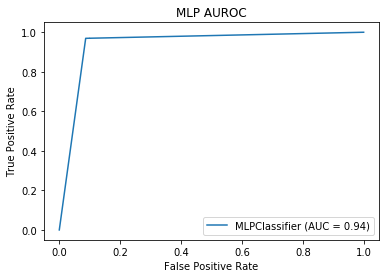

In [59]:
plot_roc_curve(pipe.named_steps['mlpclassifier'], X_valid_lg[chosen_features], y_valid_lg)
plt.title("MLP AUROC")
plt.show()

MLP performs better thatn LR on the data sets, and the AUROC is also better.   
Good.

# More thoughts:
* We can use employment_title and employement_length (time) and group them by:
 * Level
 * Industry
* Late fee: total_rec_late_fee
* PCA
* TBA

# Summary
Due to the limit of time and intension of job hunting, I will stop modeling and data exploring. Now let me give you a brief report below to summarize my findings and results.

* We scoepd the requirements: predict loan_status on the test set by giving proba of loan_status=1.
* We explored the training data and found the data is imbalanced in terms of loan_status.
* We splitted raw data into training and validation data set.
* We downsampled the training data to balance loan_status=1 and loan_status=0. We didn't downsample validation data (actually I downsampled validation data, but I never used it) because we want it to follow/simulate the distribution of test dataset.
* We brainstormed what features to choose using some intuitive definition, and then implemented RF, LR, SVM. We validated the model using CV and accuracy, then we plotted AUROC graph and tree graph. We found the definition based model is actually working quite well.
* We tried to choose other features and compare with definition based model.
* We plotted the annual_income VS loan_status graph and annual_income VS loan_stats+state to see if the income has anything to do with the loan_status.
* We built LR and RF model on feature group 1, and plotted the feature importance graph.
* Based on that, we tried to build our new feature, sub_grade_score, and it has very high importance in LR!
* We tried to use MLP, but the validation score is 92%, which is the imbalance rate, meaning MLP is not working well.
* We decided to add more continuous features on an LR model. The LR shows high score in validation set, but not good in AUROC curve. Then we plotted the feature importance graph and found top important features.
* We implemented MLP again using the top important features that we found just now, and the performance is great, as well as the AUROC score!
* SVM performs worse and slowlier than LR, RF and MLP in this specific task.
* I reran the cells sometimes so the scores might not be exactly the same with what I reported.

**So, in short, I got an LR model with AUROC at 0.98, and an MLP model with AUROC at 0.84.**  
**As an output, the predictions will be generated using the LR model.**

In [60]:
ser1 = test_df[['next_pymnt_d','total_pymnt', 'loan_amnt','loan_status']].copy()
ser1['has_next_pymnt_d'] = ser1['next_pymnt_d'].notna()
ser1['is_paid_off'] = (ser1['total_pymnt'] >= ser1['loan_amnt']) & (ser1['next_pymnt_d'].isna())
ser1['is_current'] = (ser1['total_pymnt'] < ser1['loan_amnt']) & (ser1['next_pymnt_d'].notna())

X_test = ser1[['has_next_pymnt_d', 'is_paid_off', 'is_current']]
y_test = ser1['loan_status']

In [61]:
res = pd.DataFrame(log_reg.predict_proba(X_test))
res.shape

(211627, 2)

In [62]:
output = res.rename(columns={1: 'prediction_score'}).loc[:, ['prediction_score']].reset_index()
output.head()

,index,prediction_score
0,0,0.109296
1,1,0.109296
2,2,0.000698
3,3,0.000698
4,4,0.000698


In [210]:
# output.to_csv("predictions_haibo.csv", index=False, header=True)